# psd_cs_ccf.ipynb
Abbie Stevens (<abigailstev@gmail.com>), 2022

In [1]:
import numpy as np
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from stingray.events import EventList
from stingray.lightcurve import Lightcurve
from stingray import Powerspectrum, AveragedPowerspectrum, AveragedCrossspectrum
%matplotlib inline
font_prop = font_manager.FontProperties(size=16)

/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [2]:
homedir = os.path.expanduser('~')
exe_dir = os.getcwd()
obj_name = "Swift_J0243.6+6124"
obj_prefix = "J0243"
data_dir = '%s/Reduced_data/%s/' % (homedir, obj_name)
listdir = "%s/Documents/Research/%s/in" % (homedir, obj_prefix)
assert os.path.isdir(data_dir)
data_file = "%sobs113_bary.evt" % (data_dir)
assert os.path.isfile(data_file)

In [3]:
dt = 1./2.
n_seconds = int(64)  # length of light curve segment, in seconds
broad_le = 0.2
broad_he = 12.
ref_le = 0.2
ref_he = 12.
b1_le = 0.2  # keV
b1_he = 1.  # keV
b2_le = 1.  # keV
b2_he = 2.  # keV
b3_le = 2.  # keV
b3_he = 3.  # keV
hard_le = 3.  # keV
hard_he = 12.  # keV

out_file = "%s/out/%s_%dsec_%ddt_psd-cs.fits" % \
           (exe_dir, obj_prefix, n_seconds, int(1/dt))

In [4]:
datatab = Table.read(data_file, format='fits', hdu=1)
## All MPUs, 0.2-12 keV
broad_mask = (datatab['PI'] >= int(broad_le*100)) & \
             (datatab['PI'] <= int(broad_he*100))
datatab = datatab[broad_mask]

In [5]:
gtitab = Table.read(data_file, format='fits', hdu=2)
print(gtitab)
gtis = [[i,j] for i,j in zip(gtitab['START'], gtitab['STOP'])]

      START               STOP       
        s                  s         
------------------ ------------------
120970834.86620812 120971402.88879049
120971407.88897188 120971419.88940565
120976626.02114478 120976980.03472188
120992868.43637262 120992869.43641537
120992871.43650085 120993723.97255741
120993723.97304083 120993757.95188123
120993757.95422462 120993920.47681308
121009532.86550564 121010600.90631835
121015087.00767943 121016024.04429896
121016027.04439765 121016040.04482351


## Masking for event list selections
Use masks to select the energies and detectors for analysis

In [6]:
## MPUs 0-3 are CI
## MPUs are marked by the 1st digit (0-6 incl) in the detector ID
ci_mask = datatab['DET_ID'] < 40
evts_ci = datatab[ci_mask]

## MPUs 4-6 are REF (i.e., the other ones that aren't CI)
evts_ref = datatab[~ci_mask]
## Also want ref to be 0.2-12 keV
ref_mask = (evts_ref['PI'] >= int(ref_le*100)) & \
           (evts_ref['PI'] <= int(ref_he*100))
evts_ref = evts_ref[ref_mask]

In [7]:
## All MPUs, soft band 1
b1_mask = (datatab['PI'] >= int(b1_le*100)) & \
          (datatab['PI'] < int(b1_he*100))
evts_b1 = datatab[b1_mask]

## All MPUs, soft band 2
b2_mask = (datatab['PI'] >= int(b2_le*100)) & \
          (datatab['PI'] < int(b2_he*100))
evts_b2 = datatab[b2_mask]

## All MPUs, soft band 3
b3_mask = (datatab['PI'] >= int(b3_le*100)) & \
          (datatab['PI'] < int(b3_he*100))
evts_b3 = datatab[b3_mask]

## All MPUs, hard band
hard_mask = (datatab['PI'] >= int(hard_le*100)) & \
            (datatab['PI'] <= int(hard_he*100))
evts_hard = datatab[hard_mask]

## Reference band
Make light curve and average power spectrum.

In [8]:
lc_ref = Lightcurve.make_lightcurve(evts_ref['TIME'], dt=dt, gti=gtis)
ps_ref = AveragedPowerspectrum(lc_ref, segment_size=n_seconds, norm='abs')

## Broad band

In [9]:
lc_broad = Lightcurve.make_lightcurve(datatab['TIME'], dt=dt, gti=gtis)
ps_broad = AveragedPowerspectrum(lc_broad, segment_size=n_seconds, norm='abs')

## Band 1
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [10]:
lc_b1 = Lightcurve.make_lightcurve(evts_b1['TIME'], dt=dt, gti=gtis)
ps_b1 = AveragedPowerspectrum(lc_b1, segment_size=n_seconds, norm='abs')
cs_b1 = AveragedCrossspectrum(lc_b1, lc_ref, segment_size=n_seconds)

## Band 2
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [11]:
lc_b2 = Lightcurve.make_lightcurve(evts_b2['TIME'], dt=dt, gti=gtis)
ps_b2 = AveragedPowerspectrum(lc_b2, segment_size=n_seconds, norm='abs')
cs_b2 = AveragedCrossspectrum(lc_b2, lc_ref, segment_size=n_seconds)

## Band 3
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [12]:
lc_b3 = Lightcurve.make_lightcurve(evts_b3['TIME'], dt=dt, gti=gtis)
ps_b3 = AveragedPowerspectrum(lc_b3, segment_size=n_seconds, norm='abs')
cs_b3 = AveragedCrossspectrum(lc_b3, lc_ref, segment_size=n_seconds)

## Hard band
Make light curve, average power spectrum, and average cross spectrum with the reference band.

In [13]:
lc_hard = Lightcurve.make_lightcurve(evts_hard['TIME'], dt=dt, gti=gtis)
ps_hard = AveragedPowerspectrum(lc_hard, segment_size=n_seconds, norm='abs')
cs_hard = AveragedCrossspectrum(lc_hard, lc_ref, segment_size=n_seconds)

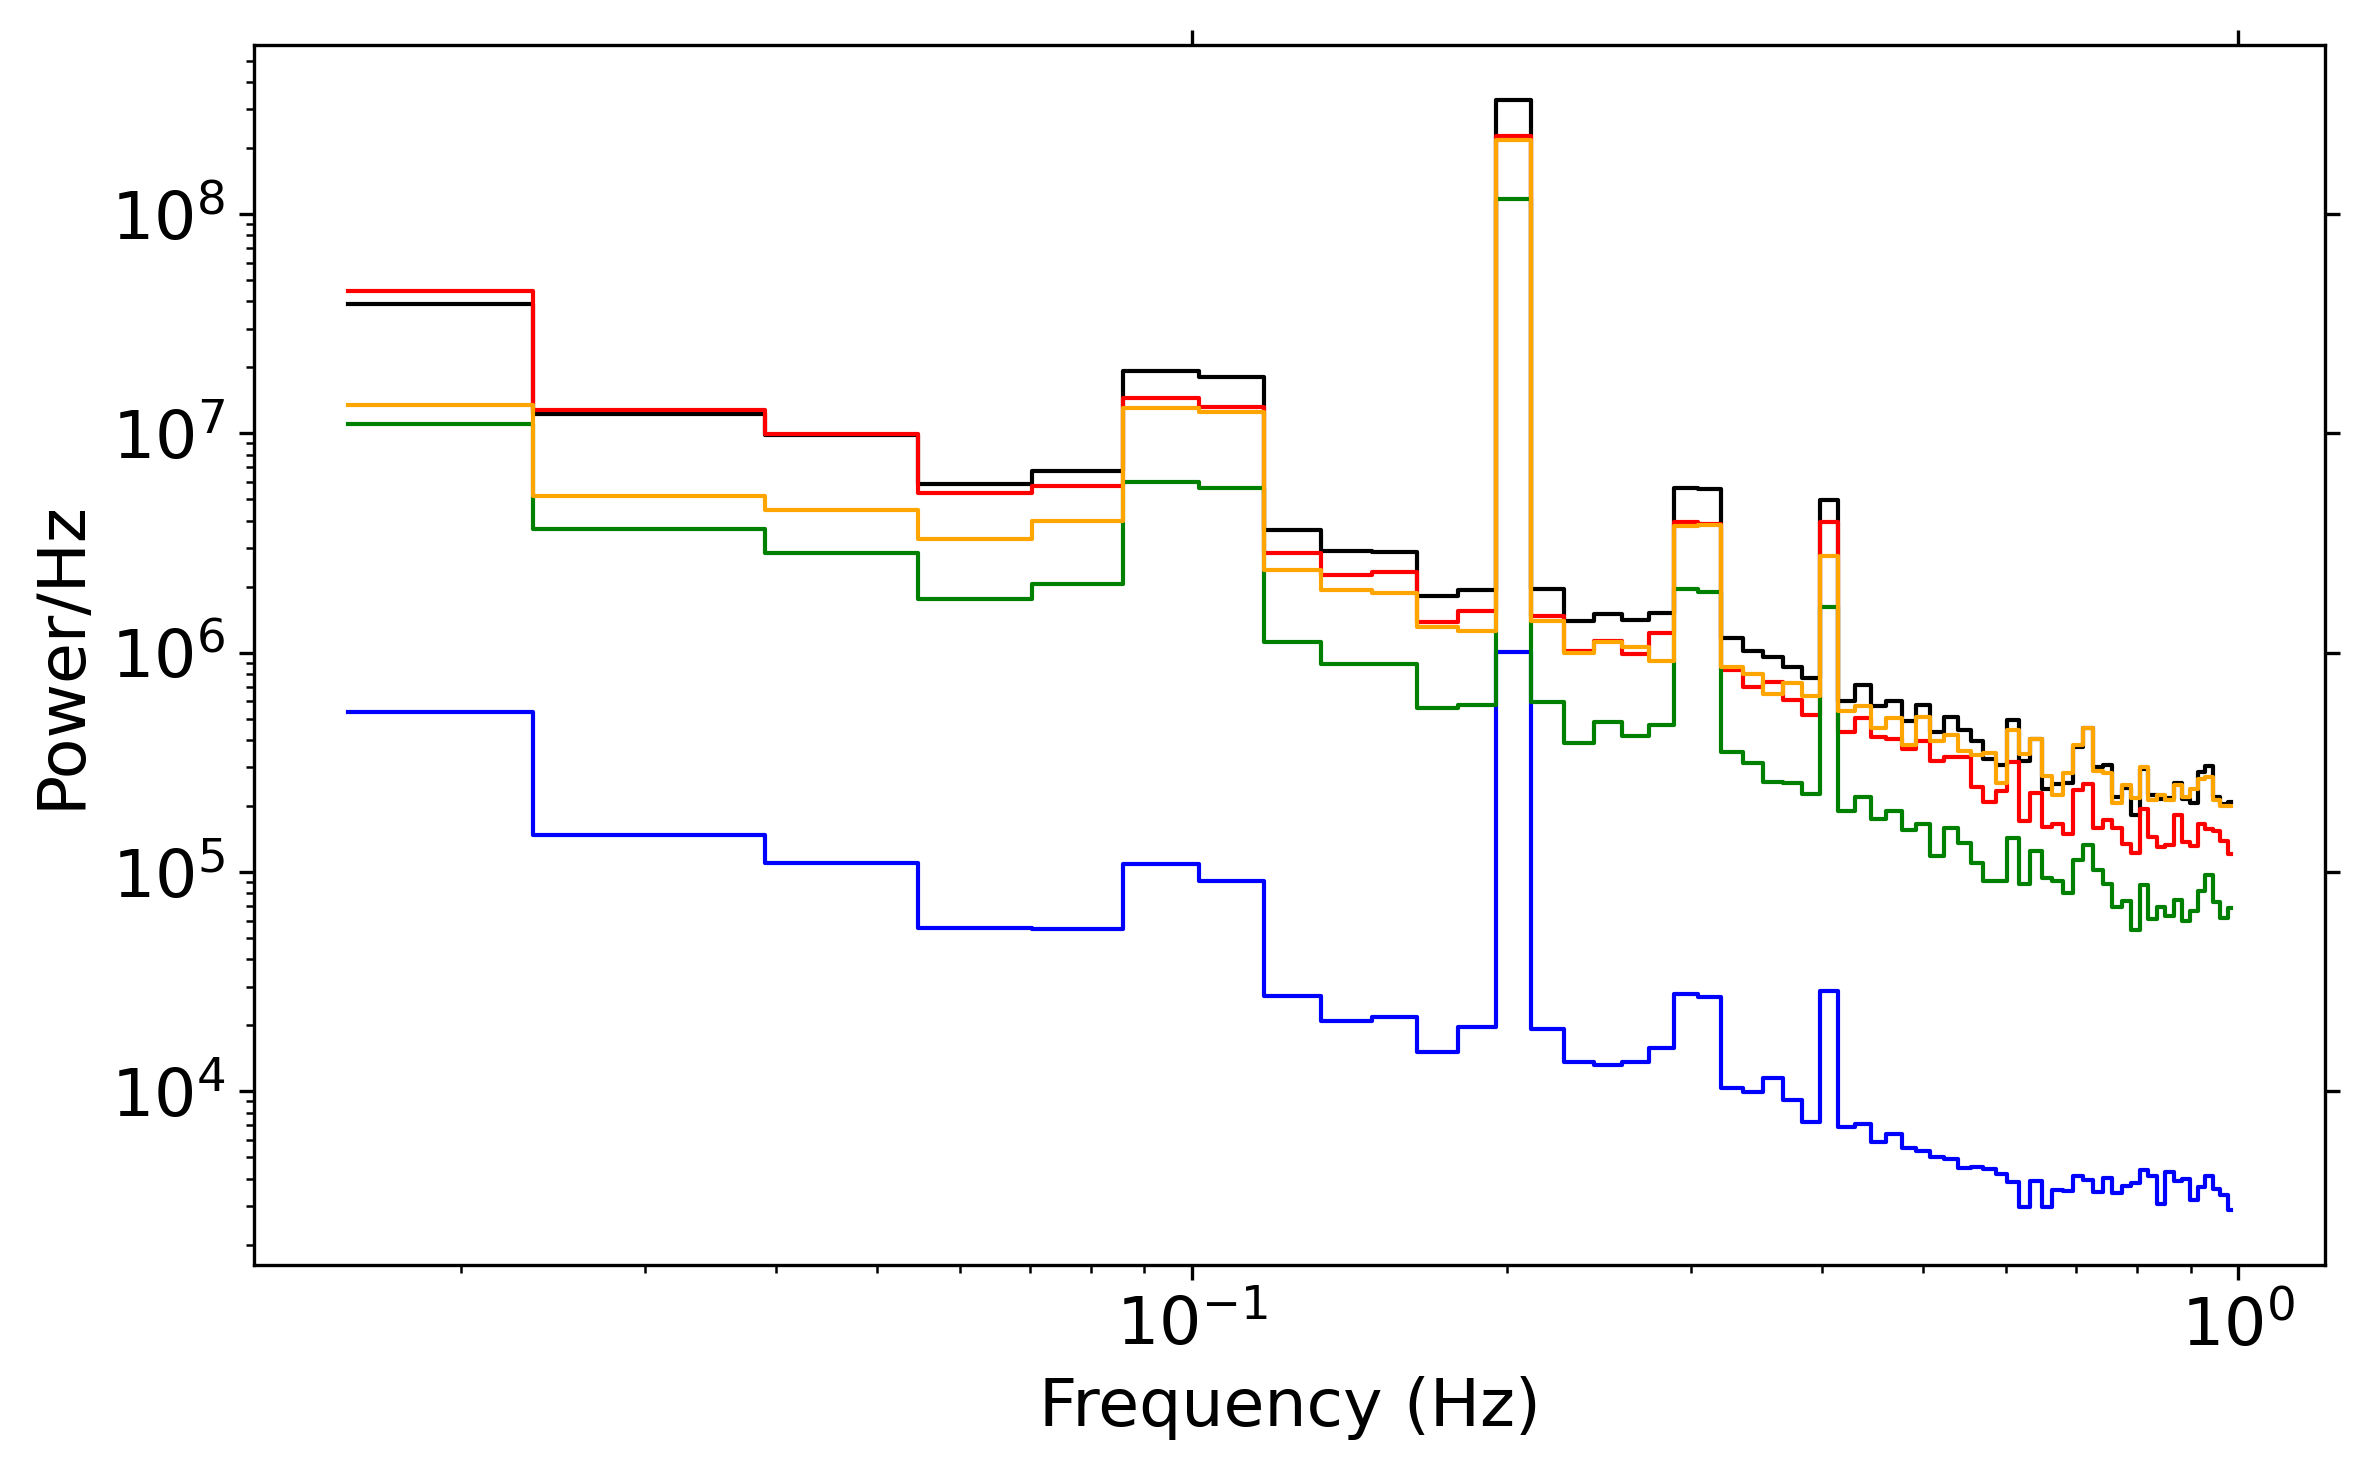

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps_ref.freq, ps_ref.power, lw=1, drawstyle='steps-mid', color='black')
ax.plot(ps_b1.freq, ps_b1.power, lw=1, drawstyle='steps-mid', color='blue')
ax.plot(ps_b2.freq, ps_b2.power, lw=1, drawstyle='steps-mid', color='red')
ax.plot(ps_b3.freq, ps_b3.power, lw=1, drawstyle='steps-mid', color='green')
ax.plot(ps_hard.freq, ps_hard.power, lw=1, drawstyle='steps-mid', color='orange')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## Channels of interest ("CI")
Make individual light curves and cross spectra of each of those with the reference band. 

In [17]:
ci_dets = np.unique(evts_ci['DET_ID'])
n_ci_dets = len(ci_dets)
n_bins = int(n_seconds/dt)
print(n_bins)

128


In [40]:
ps_ci = np.asarray([])
cs_ci = np.asarray([])
for i in range(n_ci_dets):
    indiv_det_mask = evts_ci['DET_ID'] == ci_dets[i]
    evts_det = evts_ci[indiv_det_mask]
    lc_det = Lightcurve.make_lightcurve(evts_det['TIME'], dt=dt, gti=gtis)
    ps_det = AveragedPowerspectrum(lc_det, segment_size=n_seconds, norm='none')
    ps_ci = np.append(ps_ci, ps_det)
    cs_det = AveragedCrossspectrum(lc_det, lc_ref, segment_size=n_seconds, fullspec=True, save_all=True)
    cs_ci = np.append(cs_ci, cs_det)

/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142:

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142:

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/u

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Lightcurves do not have same tseg. This means that the datafrom the two channels are not completely in sync. This might or might not be an issue. Keep an eye on it.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/c

INFO: Using legacy interface. [stingray.crossspectrum]
INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/crossspectrum.py:1908: UserWarning: The large_data option and the save_all options are onlyavailable with the legacy interface (legacy=True).
  warnings.warn("The large_data option and the save_all options are only"
INFO:astropy:Using legacy interface.


INFO: Using legacy interface. [stingray.crossspectrum]


/home/astevens/anaconda3/envs/j0243/lib/python3.9/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [47]:
print(np.shape(cs_ci))
print(dir(cs_ci[0]))
print(len(cs_ci[0].cs_all))
print(cs_ci[0].m)

(29,)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_fourier_cross', '_initialize_empty', '_initialize_from_any_input', '_make_auxil_pds', '_make_crossspectrum', '_make_segment_spectrum', '_normalize_crossspectrum', '_type', 'array_attrs', 'classical_significances', 'coherence', 'cs_all', 'df', 'dt', 'freq', 'from_astropy_table', 'from_events', 'from_lc_iterable', 'from_lightcurve', 'from_pandas', 'from_time_array', 'from_xarray', 'fullspec', 'get_meta_dict', 'gti', 'initial_checks', 'lc1', 'lc2', 'm', 'main_array_attr', 'meta_attrs', 'n', 'norm', 'nphots1', 'nphots2', 'pds1', 'pds2', 'phase_lag', 'plot', 'power', 'power_err', 'power_type', 'read', 'rebin', 'rebin_log', 'save_all', 'segment_

In [ ]:
ccf_segs = np.zeros((n_ci_dets,cs_ci[0].n, cs_ci[0].m))
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    for i in range(n_ci_dets):
        for j in range(cs_ci[0].m):
            ccf_segs[i,:,j] = ifft(cs_ci[i].cs_all[j])
    

In [19]:
print(np.shape(cs_ci))
print(cs_ci[0])

(29,)


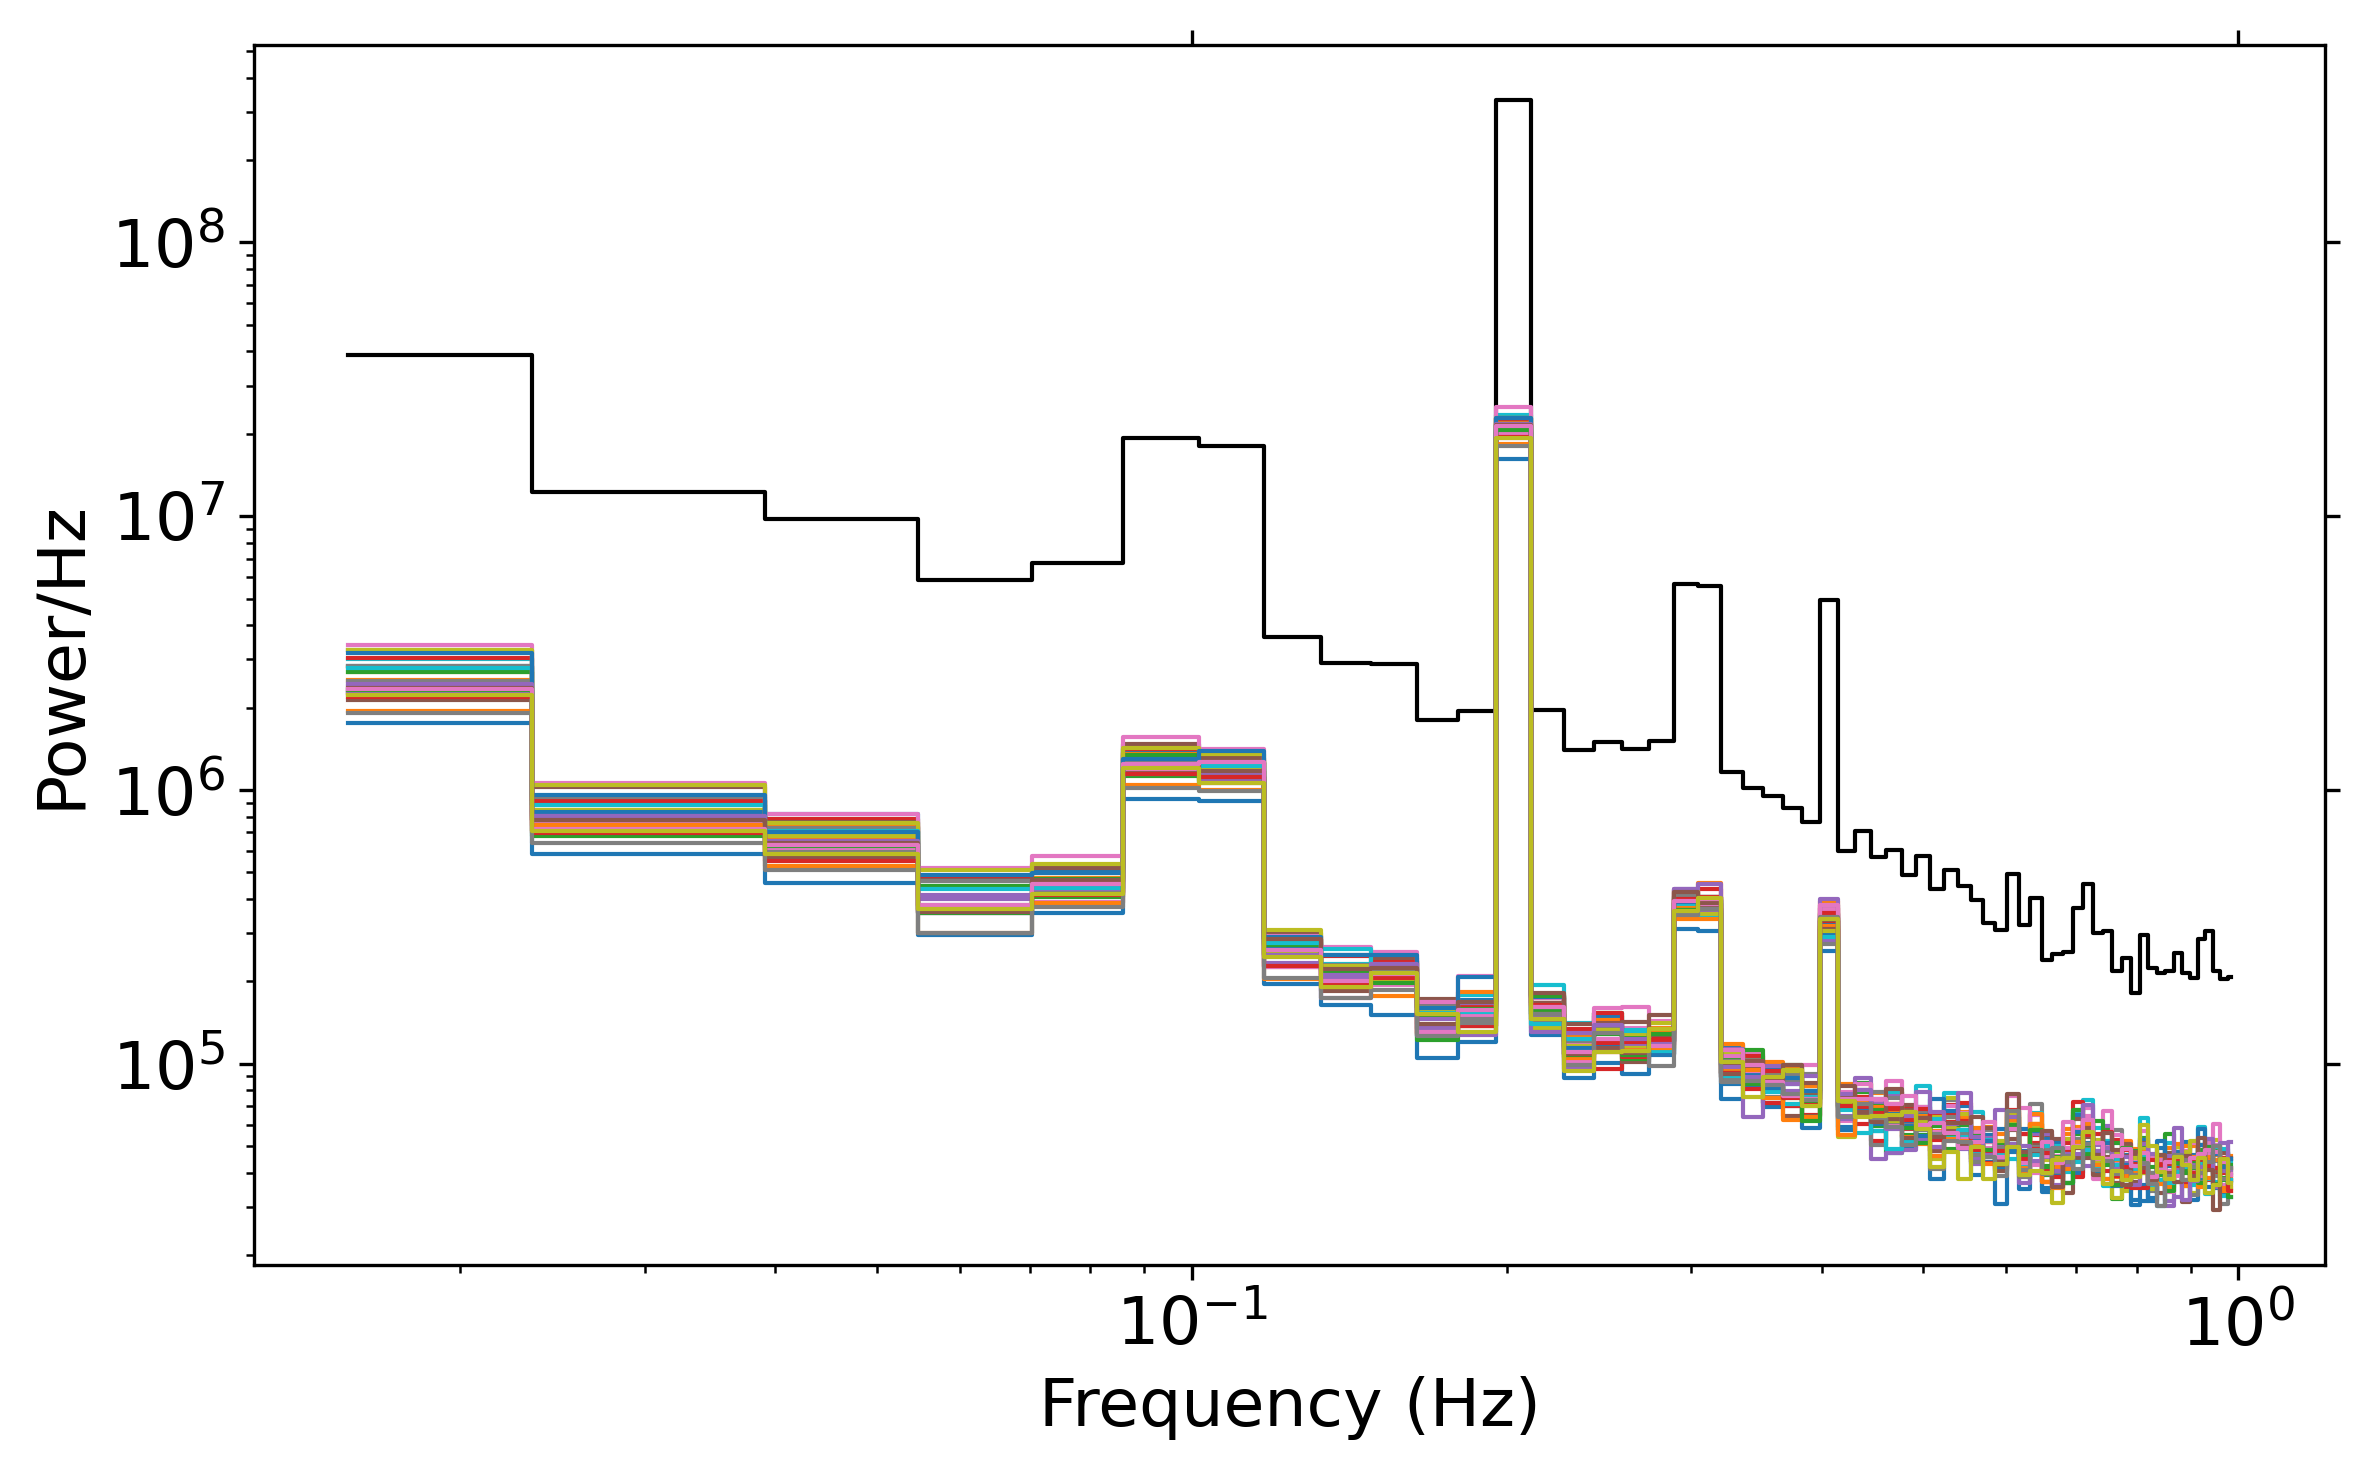

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=300, tight_layout=True)
ax.plot(ps_ref.freq, ps_ref.power, lw=1, drawstyle='steps-mid', color='black')
for i in range(n_ci_dets):
    ax.plot(ps_ci[i].freq, ps_ci[i].power, lw=1, drawstyle='steps-mid')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Frequency (Hz)", fontproperties=font_prop)
ax.set_ylabel("Power/Hz", fontproperties=font_prop)
ax.tick_params(axis='both', which='major', labelsize=16, 
               top=True, right=True, bottom=True, left=True)
plt.show()

## Making the ccf from the average cross spectra

In [49]:
from scipy.fftpack import ifft
from stingray import CrossCorrelation
import warnings

In [58]:
ccf = np.zeros((ps_ref.n, n_ci_dets))
for i in range(n_ci_dets):
    ccf[:,i] = ifft(cs_ci[i].power)

/tmp/ipykernel_71928/456712749.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  ccf[:,i] = ifft(cs_ci[i].power)


In [55]:
ccf_segs = np.zeros((ps_ref.n, n_ci_dets, ps_ref.m))
with warnings.catch_warnings():
    # this will suppress all warnings in this block
    warnings.simplefilter("ignore")
    for i in range(n_ci_dets):
        for j in range(ps_ref.m):
            ccf_segs[:,i,j] = ifft(cs_ci[i].cs_all[j].power)
avg_ccf = np.mean(ccf_segs, axis=2)

In [64]:
assert np.isclose(ccf[2,2],avg_ccf[2,2], atol=1e-8), "Check CCF inputs, the results don't match."

### Normalize the ccf as in Stevens & Uttley 2016

In [33]:
if ps_ref.norm != "abs":
    ps_ref.norm = 'abs'
ref_rms = np.sqrt(np.sum(ps_ref.power * ps_ref.df))  ## Assuming absolute rms normalization
# divide by the ref band rms and normalize
ccf *= 2.0 / float(ps_ref.n) / ref_rms
ccf_segs *= 2.0 / float(ps_ref.n) / ref_rms

2784.964917938048


### Standard error on the CCF

In [66]:
## Compute the standard error on each ccf bin from the segment-to-segment variations.
ccf_resid = (ccf_segs.T - avg_ccf.T).T
## Eqn 2.3 from S. Vaughan 2013, "Scientific Inference"
sample_var = np.sum(ccf_resid ** 2, axis=2) / (ps_ref.n - 1)
## Eqn 2.4 from S. Vaughan 2013, "Scientific Inference"
ccf_err = np.sqrt(sample_var / ps_ref.n)

(128, 29, 58)


In [67]:
print(np.shape(ccf_err))

(128, 29)


In [68]:
print(ccf_err[2,2])

0.00041634180338301206


In [69]:
print(ccf[2,2])

1.0256772524417859


## Need to save ccf and error to a FITS file
(check old psd_cs_ccf.py)

In [ ]:
## Putting everyting into a table
print("* Putting PSDs and CS into a table")
tab = Table()
tab.add_column(Column(name="FREQUENCY", data=freq, unit="Hz",
                      dtype='float32', description="Fourier frequency"))

assert len(psd_broad) == n_bins, "psd_broad has wrong length: %d" % \
                                 (len(psd_broad))
assert np.isfinite(psd_broad).any(), "psd_broad has infinite value(s)."
assert not np.isnan(psd_broad).any(), "psd_broad has NaN value(s)."
tab.add_column(Column(name="PSD_BROAD", data=psd_broad, dtype='float64',
                      unit="rms^2",
                      description="PSD of all MPUs, %.2f-%.2f keV, "\
                                  "w Poiss noise" % (broad_le, broad_he)))

assert len(psd_ref) == n_bins, "psd_ref has wrong length: %d" % \
                               (len(psd_ref))
assert np.isfinite(psd_ref).any(), "psd_ref has infinite value(s)."
assert not np.isnan(psd_ref).any(), "psd_ref has NaN value(s)."
tab.add_column(Column(name="PSD_REF", data=psd_ref, dtype='float64',
                      unit="rms^2",
                      description="Ref power spectrum, %.2f-%.2f keV, "\
                                  "w Poiss noise" % (ref_le, ref_he)))

assert np.shape(psd_ci) == (n_bins, n_chans), \
    "psd_ci has wrong shape: %s" % (str(np.shape(psd_ci)))
assert np.isfinite(psd_ci).any(), "psd_ci has infinite value(s)."
assert not np.isnan(psd_ci).any(), "psd_ci has NaN value(s)."
tab.add_column(Column(name="PSD_CI", data=psd_ci, dtype='float64',
                      unit="rms^2",
                      description="CI power spectrum, w Poiss noise"))

assert np.shape(cross) == (n_bins, n_chans), \
    "cross has wrong shape: %s" % (str(np.shape(cross)))
assert np.isfinite(cross).any(), "cross has infinite value(s)."
assert not np.isnan(cross).any(), "cross has NaN value(s)."
tab.add_column(Column(name="CROSS", data=cross, dtype='c16',
                      description="Cross spectrum, unnorm"))

assert len(cs_b1) == n_bins, "cs_b1 has wrong length: %d" % (len(cs_b1))
assert np.isfinite(cs_b1).any(), "cs_b1 has infinite value(s)."
assert not np.isnan(cs_b1).any(), "cs_b1 has NaN value(s)."
tab.add_column(Column(name="CS_B1", data=cs_b1, dtype='c16',
                      description="CS of hard band w soft band 1, unnorm"))

assert len(cs_b2) == n_bins, "cs_b2 has wrong length: %d" % (len(cs_b2))
assert np.isfinite(cs_b2).any(), "cs_b2 has infinite value(s)."
assert not np.isnan(cs_b2).any(), "cs_b2 has NaN value(s)."
tab.add_column(Column(name="CS_B2", data=cs_b2, dtype='c16',
                      description="CS of hard band w soft band 2, unnorm"))

assert len(cs_b3) == n_bins, "cs_b3 has wrong length: %d" % (len(cs_b3))
assert np.isfinite(cs_b3).any(), "cs_b3 has infinite value(s)."
assert not np.isnan(cs_b3).any(), "cs_b3 has NaN value(s)."
tab.add_column(Column(name="CS_B3", data=cs_b3, dtype='c16',
                      description="CS of hard band w soft band 3, unnorm"))

assert len(psd_b1) == n_bins, "psd_b1 has wrong length: %d" % (len(psd_b1))
assert np.isfinite(psd_b1).any(), "psd_b1 has infinite value(s)."
assert not np.isnan(psd_b1).any(), "psd_b1 has NaN value(s)."
tab.add_column(Column(name="PSD_B1", data=psd_b1, dtype='float64',
                      unit="rms^2",
                      description="PSD of soft band 1, w Poiss noise"))
assert len(psd_b2) == n_bins, "psd_b2 has wrong length: %d" % (len(psd_b2))
assert np.isfinite(psd_b2).any(), "psd_b2 has infinite value(s)."
assert not np.isnan(psd_b2).any(), "psd_b2 has NaN value(s)."
tab.add_column(Column(name="PSD_B2", data=psd_b2, dtype='float64',
                      unit="rms^2",
                      description="PSD of soft band 2, w Poiss noise"))

assert len(psd_b3) == n_bins, "psd_b3 has wrong length: %d" % (len(psd_b3))
assert np.isfinite(psd_b3).any(), "psd_b3 has infinite value(s)."
assert not np.isnan(psd_b3).any(), "psd_b3 has NaN value(s)."
tab.add_column(Column(name="PSD_B3", data=psd_b3, dtype='float64',
                      unit="rms^2",
                      description="PSD of soft band 3, w Poiss noise"))

assert len(psd_hard) == n_bins, "psd_hard has wrong length: %d" % \
                                (len(psd_hard))
assert np.isfinite(psd_hard).any(), "psd_hard has infinite value(s)."
assert not np.isnan(psd_hard).any(), "psd_hard has NaN value(s)."
tab.add_column(Column(name="PSD_HARD", data=psd_hard, dtype='float64',
                      unit="rms^2",
                      description="PSD of hard band, w Poiss noise"))

tab.add_column(Column(name="TIMEBINS", data=np.arange(n_bins), unit='bin',
                      dtype='int32', description="CCF time bins"))
assert len(mean_ccf) == n_bins, "mean_ccf has wrong length: %d" % \
                                (len(mean_ccf))
assert np.isfinite(mean_ccf).any(), "mean_ccf has infinite value(s)."
assert not np.isnan(mean_ccf).any(), "mean_ccf has NaN value(s)."
tab.add_column(Column(name="CCF", data=mean_ccf, dtype='float64',
                      unit="ct/s", description="Average CCF from CROSS"))

assert len(ccf_err) == n_bins, "ccf_err has wrong length: %d" % \
                                (len(ccf_err))
assert np.isfinite(ccf_err).any(), "ccf_err has infinite value(s)."
assert not np.isnan(ccf_err).any(), "ccf_err has NaN value(s)."
tab.add_column(Column(name="CCF_ERR", data=ccf_err, dtype='float64',
                      unit="ct/s", description="Error on CCF"))

######################
## Saving the output!
######################
tab.meta['OBJECT'] = obj_name
tab.meta['INST'] = "NICER"
tab.meta['TODAY'] = str(datetime.now())
tab.meta['TYPE'] = file_type
tab.meta['INFILE'] = input_file
tab.meta['EXPOSURE'] = n_seconds * n_seg
tab.meta['N_BINS'] = n_bins
tab.meta['DT'] = dt
tab.meta['DF'] = df
tab.meta['N_CHANS'] = n_chans
tab.meta['CHBINFIL'] = binning_file
tab.meta['N_SEG'] = n_seg
tab.meta['N_SECOND'] = n_seconds
#tab.meta['NYQUIST'] = 1./(2.*dt)
# tab.meta['N_DETS'] = "%s" % np.array2string(all_n_dets, formatter={'int_kind': lambda x: "%d" % x}, separator=', ')
# tab.meta['N_CI_DETS'] = "%s" % np.array2string(all_n_ci_dets, formatter={'int_kind': lambda x: "%d" % x}, separator=', ')
tab.meta['N_DETS'] = str(all_n_dets.tolist())
tab.meta['N_CIDETS'] = str(all_n_ci_dets.tolist())
tab.meta['RATE_REF'] = mean_rate_ref
tab.meta['REF_RMS'] = ref_rms
# tab.meta['RATE_CI'] = "%s" % np.array2string(mean_rate_ci, formatter={'float_kind': lambda x: "%.4f" % x}, separator=', ')
#tab.meta['RATE_CI'] = str(mean_rate_ci.tolist())
#tab.meta['RATE_BROAD'] = mean_rate_broad
#tab.meta['RANGE_B1'] = "%.2f-%.2f-keV" % (b1_le, b1_he)
#tab.meta['RATE_B1'] = mean_rate_b1
#tab.meta['RANGE_B2'] = "%.2f-%.2f-keV" % (b2_le, b2_he)
#tab.meta['RATE_B2'] = mean_rate_b2
#tab.meta['RANGE_B3'] = "%.2f-%.2f-keV" % (b3_le, b3_he)
#tab.meta['RATE_B3'] = mean_rate_b3
#tab.meta['RANGE_HARD'] = "%.2f-%.2f-keV" % (hard_le, hard_he)
#tab.meta['RATE_HARD'] = mean_rate_hard

print(tab.info)
print(tab.meta)
print(np.array2string(all_n_dets, formatter={'int_kind': lambda x: "%d" % x}, separator=', '))
print(np.array2string(mean_rate_ci, formatter={'float_kind': lambda x: "%.4f" % x}, separator=','))
if debug:
    out_file = out_file.replace("out/", "out/debug_")

# print("Ignore the following FITS unit warning.")
warnings.simplefilter('ignore', category=AstropyWarning)
tab.write(out_file, format='fits', overwrite=True)
print("Output saved to: %s \n" % out_file)
